In [ ]:
# Hand Siganture similarity check using Siamese Neural Network (SNN)
## Kaggle Notebook - T4 GPU

In [1]:
###### Importing dependencies

import os
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR
from typing import Tuple
from skimage.io import imread
from skimage import img_as_ubyte
from skimage import filters, transform
from collections import defaultdict, Counter, OrderedDict

# Adjusting the plotting:
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

In [2]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
###### Setting-up the device

!nvidia-smi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mon Jun 24 08:36:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
device

device(type='cuda')

In [5]:
###### Data CSVs

# train data
train_df = pd.read_csv("/kaggle/input/signature-verification-dataset/sign_data/train_data.csv")
# test data
test_df = pd.read_csv("/kaggle/input/signature-verification-dataset/sign_data/test_data.csv")

In [6]:
train_df

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1
...,...,...,...
23200,031/02_031.png,031/03_031.png,0
23201,031/02_031.png,031/12_031.png,0
23202,031/02_031.png,031/11_031.png,0
23203,031/02_031.png,031/06_031.png,0


In [7]:
test_df

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1
...,...,...,...
5742,066/01_066.png,066/06_066.png,0
5743,066/01_066.png,066/08_066.png,0
5744,066/01_066.png,066/02_066.png,0
5745,066/01_066.png,066/05_066.png,0


In [8]:
###### Cleaning the dataframes

# train data
train_df["real_images"] = train_df["068/09_068.png"].apply(lambda x: f"/kaggle/input/signature-verification-dataset/sign_data/train/{x}")
train_df["forged_images"] = train_df["068_forg/03_0113068.PNG"].apply(lambda x: f"/kaggle/input/signature-verification-dataset/sign_data/train/{x}")
train_df.drop(["068_forg/03_0113068.PNG"], axis=1, inplace=True)
train_df.drop(["068/09_068.png"], axis=1, inplace=True)
train_df.rename(columns={'1':'label'}, inplace=True)

# test data
test_df["real_images"] = test_df["068/09_068.png"].apply(lambda x: f"/kaggle/input/signature-verification-dataset/sign_data/test/{x}")
test_df["forged_images"] = test_df["068_forg/03_0113068.PNG"].apply(lambda x: f"/kaggle/input/signature-verification-dataset/sign_data/test/{x}")
test_df.drop(["068_forg/03_0113068.PNG"], axis=1, inplace=True)
test_df.drop(["068/09_068.png"], axis=1, inplace=True)
test_df.rename(columns={'1':'label'}, inplace=True)

In [9]:
train_df

,label,real_images,forged_images
0,1,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
1,1,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
2,1,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
3,1,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
4,1,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
...,...,...,...
23200,0,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
23201,0,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
23202,0,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
23203,0,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...


In [10]:
test_df

,label,real_images,forged_images
0,1,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
1,1,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
2,1,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
3,1,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
4,1,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
...,...,...,...
5742,0,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
5743,0,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
5744,0,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...
5745,0,/kaggle/input/signature-verification-dataset/s...,/kaggle/input/signature-verification-dataset/s...


In [11]:
print("Train Label proportions")
train_df["label"].value_counts(normalize=True)

Train Label proportions


label
0    0.543073
1    0.456927
Name: proportion, dtype: float64

In [12]:
print("Test Label proportions")
test_df["label"].value_counts(normalize=True)

Test Label proportions


label
1    0.517661
0    0.482339
Name: proportion, dtype: float64

In [13]:
###### Configuration

class Config:
    
    debug = False # when True enables debug mode for quick testing
    print_freq=100
    num_workers = 4 # number of worker threads for data loading
    
    img_size = (170,242) # the size that will be used to resize (rescale) the signature
    input_size = (150, 220) # the final size of the signature, obtained by croping the center of image
    canvas_size = (840, 1360) # The size of a canvas where the signature will be centered on. Should be larger than the signature
    
    epochs = 10 # number of epochs
    batch_size = 1024 # number of samples per batch
    lr = 1e-3 # learning rate
    weight_decay = 1e-3 # weight decay (L2 penalty)
    gradient_accumulation_steps = 1 # number of steps to accumulate gradients before updating
    max_grad_norm = 1000 # maximum gradient norm for clipping
    target_size = train_df["label"].shape[0] # number of target classes (derived from the training data labels)
    nfolds = 5 # number of folds for cross-validation
    trn_folds = [0] # list of training folds to use
    model_name = 'convnet' # name of the model architecture to use: 'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'tresnet_m'
    train = True # train the model
    early_stop = True # use early stopping
    target_col = "label" # column name for the target variable in the dataset
    projection2d = True # use 2D projections
    fc_dim = 512 # dimension of the fully connected layer
    early_stopping_steps = 5 # number of steps to wait before early stopping
    grad_cam = False # use Grad-CAM for visualization
    seed = 42 # random seed for reproducibility
    scheduler = "CosineAnnealingLR" # learning rate scheduler, 
                                    # other options: ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    # CosineAnnealingLR params
    cosanneal_params = {
        'T_max': 4, # maximum number of iterations
        'eta_min': 1e-5, # minimum learning rate
        'last_epoch': -1 # index of the last epoch
    }
    # ReduceLROnPlateau params
    reduce_params = {
        'mode': 'min', # mode of operation
        'factor': 0.2, # factor by which the lr will be reduced
        'patience': 4, # number of epochs to wait before reducing the lr
        'eps': 1e-6, # minimum change to qualify as an improvement
        'verbose': True # print messages about lr changes
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params = {
        'T_0': 3, # number of iterations for the first restart
        'eta_min': 1e-6, # minimum learning rate
        'T_mult': 1, # factor increases T_0 after a restart
        'last_epoch': -1 # index of the last epoch
    }
    # OneCycleLR params
    onecycle_params = {
        'pct_start': 0.1, # percentage of the cycle to increase the lr
        'div_factor': 1e2, # initial division factor for lr
        'max_lr': 1e-3, # maximum learning rate
        'steps_per_epoch': 7, # number of steps per epoch
        'epochs': 7 # number of epochs in the cycle
    }
    
if Config.debug: # enable debug
    Config.epochs = 1
    train = train_df.sample(n=1000, random_state=Config.seed).reset_index(drop=True)

In [14]:
###### Utils

def get_score(y_true, y_pred):
    score = accuracy_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=Config.seed)

In [15]:
###### Pre-processing

def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] = (170, 242),
                         input_size: Tuple[int, int] = (150, 220)) -> np.ndarray:
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)
    
    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized
        
    return cropped

def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center
    
    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0
            
    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image

def remove_background(img: np.ndarray) -> np.ndarray:
    img = img.astype(np.uint8)
    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    img[img > threshold] = 255

    return img

def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')

    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [16]:
canvas_size = (952, 1360)
img_size = (128, 128)
input_size = (256, 256)

observation = train_df.iloc[0]
img1 = load_signature(observation["real_images"])
img2 = load_signature(observation["forged_images"])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

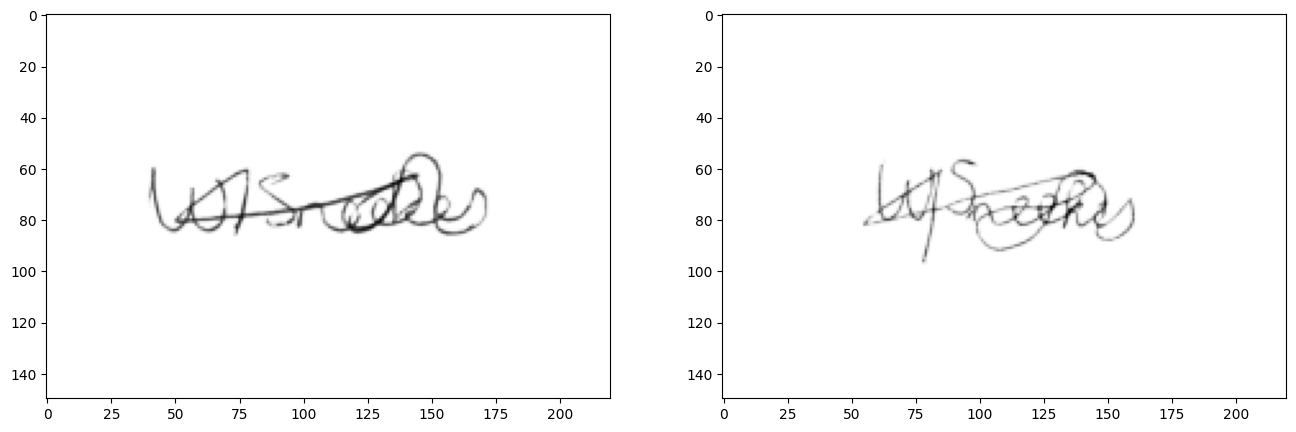

In [17]:
# Shows pre-processed samples of the two users

f, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].imshow(preprocessed_img1)
ax[1].imshow(preprocessed_img2)

In [18]:
###### Dataset

class SignatureDataset(Dataset):
    
    def __init__(self, df, canvas_size, dim=(256, 256)):
        self.df  = df
        self.real_file_names = df["real_images"].values
        self.forged_file_names = df["forged_images"].values
        self.labels = df["label"].values
        self.dim = dim
        self.canvas_size=canvas_size

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,index):
        # getting the image path
        real_file_path = self.real_file_names[index]
        forged_file_path = self.forged_file_names[index]
        
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)
        
        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)
        
        label = torch.tensor(self.labels[index], dtype=torch.long)
        
        return torch.tensor(img1), torch.tensor(img2), label.float()

label:  1.0


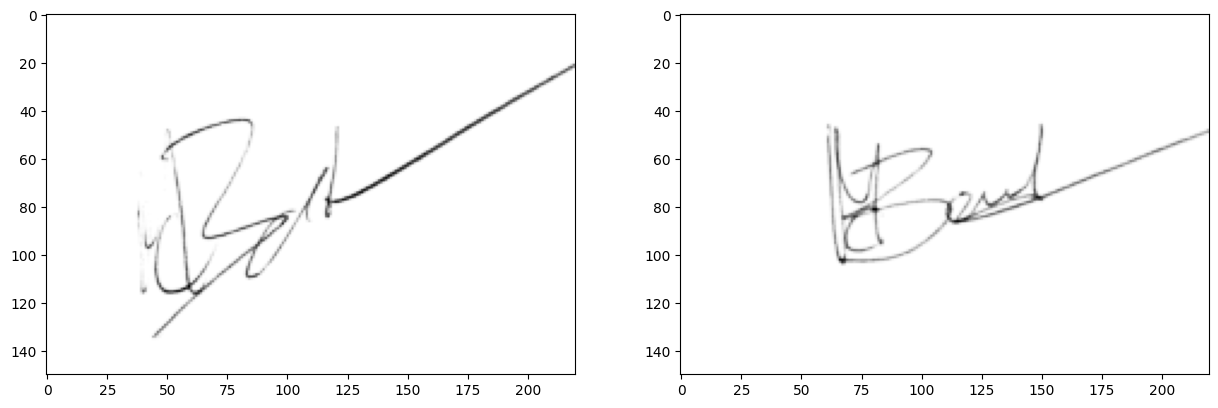

In [19]:
train_dataset = SignatureDataset(train_df, canvas_size, input_size)
img1, img2, y = train_dataset[1111]

f, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(img1)
ax[1].imshow(img2)
print("label: ", y.numpy())

In [20]:
###### Contrastive Loss

class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.cosine_similarity(F.normalize(output1), F.normalize(output2))
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [21]:
###### Model - SigNet - Siamese Neural Network

class SigNet(nn.Module):
    
    def __init__(self):
        super(SigNet, self).__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_mish(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_mish(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_mish(256, 384, 3, pad=1)),
            ('conv4', conv_bn_mish(384, 384, 3, pad=1)),
            ('conv5', conv_bn_mish(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_mish(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_mish(self.feature_space_size, self.feature_space_size)),
        ]))
    
    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        # forward pass of input 1
        output1 = self.forward_once(img1)
        # forward pass of input 2
        output2 = self.forward_once(img2)
        return output1, output2


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('mish', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('mish', nn.Mish()),
    ]))

class SiameseModel(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.model = SigNet()
        state_dict, _, _ = torch.load("/kaggle/input/pretrained-signet-weights/pytorch/v0/1/signet.pth")
        self.model.load_state_dict(state_dict)
        
        if Config.projection2d:
            self.probs = nn.Linear(4, 1)
        else:
            self.probs = nn.Linear(self.model.feature_space_size*2, 1)
        self.projection2d = nn.Linear(self.model.feature_space_size, 2)
    
    def forward_once(self, img):
        x = self.model.forward_once(img)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        # forward pass of input 1
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        embedding1 = self.forward_once(img1)
        # forward pass of input 2
        embedding2 = self.forward_once(img2)
        
        if Config.projection2d:
            #print("Project embeddings into 2d space")
            embedding1 = self.projection2d(embedding1)
            embedding2 = self.projection2d(embedding2)
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output
        else:
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            print(output.shape)
            output= self.probs(output)
            return embedding1, embedding2, output

In [22]:
###### Helper functions

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterions, optimizer, epoch, scheduler, device):
    
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (img1, img2, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        labels = labels.to(device)
        batch_size = labels.size(0)
        out1, out2, preds = model(img1, img2)
        loss1 = criterions[0](out1, out2, labels)
        loss2 = criterions[1](preds.squeeze(1), labels)
        loss = (loss1 + loss2) / 2
            
        # record loss
        losses.update(loss.item(), batch_size)
        if Config.gradient_accumulation_steps > 1:
            loss = loss / Config.gradient_accumulation_steps
        
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        if (step + 1) % Config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print(f'Epoch: [{epoch}][{step}/{len(train_loader)}] ', end='')
            print(f'Elapsed: {timeSince(start, float(step+1)/len(train_loader))} ', end='')
            print(f'Loss: {losses.val:.4f}({losses.avg:.4f}) ', end='')
            print(f'Grad: {grad_norm:.4f} ', end='')
            if scheduler:
                print(f'LR: {scheduler.get_last_lr()[0]:.6f}  ')
            else:
                print(f'LR: {Config.lr}')

    return losses.avg

In [23]:
###### Training

# loader
seed_torch(seed=Config.seed)

train_dataset = SignatureDataset(train_df, Config.canvas_size, dim=(256, 256))

train_loader = DataLoader(train_dataset,
                              batch_size=Config.batch_size, 
                              shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)
   
# scheduler 
def get_scheduler(optimizer):
    if Config.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, **Config.reduce_params)
    elif Config.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, **Config.cosanneal_params)
    elif Config.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, **Config.reduce_params)
    elif Config.scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, **Config.onecycle_params)
    return scheduler

# model & optimizer
model = SiameseModel()
model.to(device)

optimizer = Adam(model.parameters(), lr=Config.lr, weight_decay=Config.weight_decay)
try:
    scheduler = get_scheduler(optimizer)
except:
    print('Learning scheduler is not used')

# loop
contrastive = ContrastiveLoss() # Contrastive loss
binary_cross = nn.BCEWithLogitsLoss() # Binary cross entropy
best_score = 0.
best_loss = np.inf
    
for epoch in range(Config.epochs):
        
    start_time = time.time()
        
    # train
    avg_loss = train_fn(train_df, train_loader, model, [contrastive, binary_cross], optimizer, epoch, scheduler, device)
        
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, OneCycleLR):
        scheduler.step()

    elapsed = time.time() - start_time

    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s') 

    if avg_loss < best_loss:
        best_loss = avg_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict()}, 
                        OUTPUT_DIR+f'{Config.model_name}_best_loss.pt')


Epoch: [0][0/22] Elapsed: 2m 30s (remain 52m 32s) Loss: 0.6940(0.6940) Grad: 12.2629 LR: 0.001000  
Epoch: [0][21/22] Elapsed: 13m 47s (remain 0m 0s) Loss: 0.4426(0.5877) 

Epoch 1 - avg_train_loss: 0.5877  time: 828s
Epoch 1 - Save Best Loss: 0.5877 Model


Grad: 0.7830 LR: 0.001000  
Epoch: [1][0/22] Elapsed: 2m 26s (remain 51m 7s) Loss: 0.4026(0.4026) Grad: 1.1403 LR: 0.000855  
Epoch: [1][21/22] Elapsed: 13m 39s (remain 0m 0s) Loss: 0.2351(0.3329) 

Epoch 2 - avg_train_loss: 0.3329  time: 820s
Epoch 2 - Save Best Loss: 0.3329 Model


Grad: 0.8310 LR: 0.000855  
Epoch: [2][0/22] Elapsed: 2m 24s (remain 50m 36s) Loss: 0.2177(0.2177) Grad: 0.6030 LR: 0.000505  
Epoch: [2][21/22] Elapsed: 13m 38s (remain 0m 0s) Loss: 0.1420(0.1833) 

Epoch 3 - avg_train_loss: 0.1833  time: 819s
Epoch 3 - Save Best Loss: 0.1833 Model


Grad: 0.5691 LR: 0.000505  
Epoch: [3][0/22] Elapsed: 2m 23s (remain 50m 18s) Loss: 0.1262(0.1262) Grad: 0.5312 LR: 0.000155  
Epoch: [3][21/22] Elapsed: 13m 38s (remain 0m 0s) Loss: 0.1132(0.1217) 

Epoch 4 - avg_train_loss: 0.1217  time: 820s
Epoch 4 - Save Best Loss: 0.1217 Model


Grad: 0.5844 LR: 0.000155  
Epoch: [4][0/22] Elapsed: 2m 22s (remain 49m 57s) Loss: 0.1128(0.1128) Grad: 0.4851 LR: 0.000010  
Epoch: [4][21/22] Elapsed: 13m 36s (remain 0m 0s) Loss: 0.0996(0.1065) 

Epoch 5 - avg_train_loss: 0.1065  time: 817s
Epoch 5 - Save Best Loss: 0.1065 Model


Grad: 0.4847 LR: 0.000010  
Epoch: [5][0/22] Elapsed: 2m 22s (remain 49m 49s) Loss: 0.1078(0.1078) Grad: 0.5512 LR: 0.000155  
Epoch: [5][21/22] Elapsed: 13m 38s (remain 0m 0s) Loss: 0.0846(0.0958) 

Epoch 6 - avg_train_loss: 0.0958  time: 819s
Epoch 6 - Save Best Loss: 0.0958 Model


Grad: 0.5244 LR: 0.000155  
Epoch: [6][0/22] Elapsed: 2m 27s (remain 51m 32s) Loss: 0.0862(0.0862) Grad: 0.8602 LR: 0.000505  
Epoch: [6][21/22] Elapsed: 13m 45s (remain 0m 0s) Loss: 0.0670(0.0849) 

Epoch 7 - avg_train_loss: 0.0849  time: 827s
Epoch 7 - Save Best Loss: 0.0849 Model


Grad: 0.4787 LR: 0.000505  
Epoch: [7][0/22] Elapsed: 2m 23s (remain 50m 23s) Loss: 0.0589(0.0589) Grad: 0.4315 LR: 0.000855  
Epoch: [7][21/22] Elapsed: 13m 35s (remain 0m 0s) Loss: 0.0334(0.0441) 

Epoch 8 - avg_train_loss: 0.0441  time: 817s
Epoch 8 - Save Best Loss: 0.0441 Model


Grad: 0.4607 LR: 0.000855  
Epoch: [8][0/22] Elapsed: 2m 23s (remain 50m 13s) Loss: 0.0333(0.0333) Grad: 0.3706 LR: 0.001000  
Epoch: [8][21/22] Elapsed: 13m 37s (remain 0m 0s) Loss: 0.1235(0.1795) 

Epoch 9 - avg_train_loss: 0.1795  time: 818s


Grad: 0.6905 LR: 0.001000  
Epoch: [9][0/22] Elapsed: 2m 23s (remain 50m 20s) Loss: 0.1070(0.1070) Grad: 0.5460 LR: 0.000855  
Epoch: [9][21/22] Elapsed: 13m 41s (remain 0m 0s) Loss: 0.0348(0.0578) 

Epoch 10 - avg_train_loss: 0.0578  time: 822s


Grad: 0.4808 LR: 0.000855  


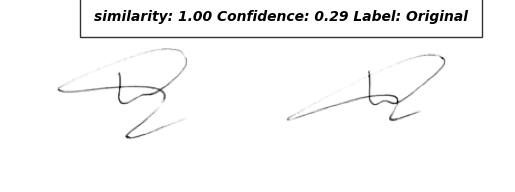

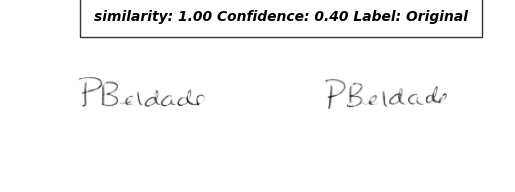

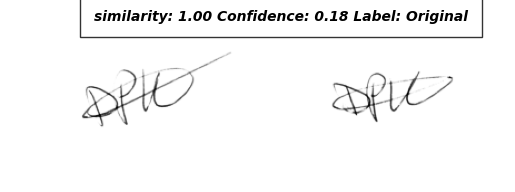

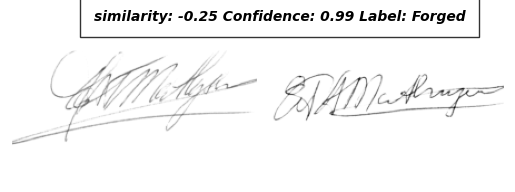

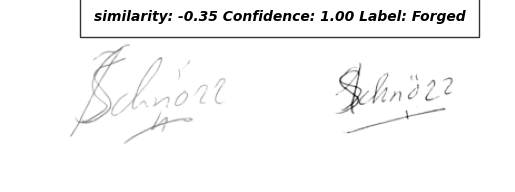

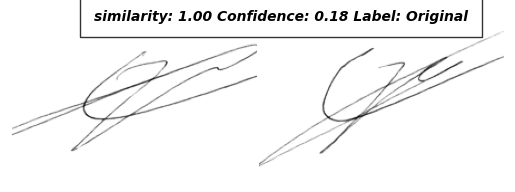

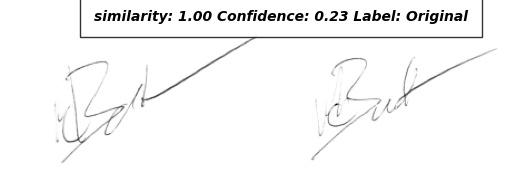

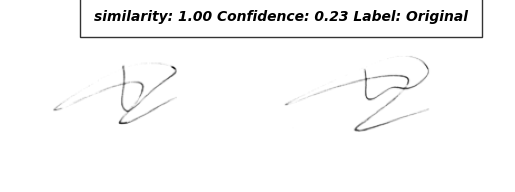

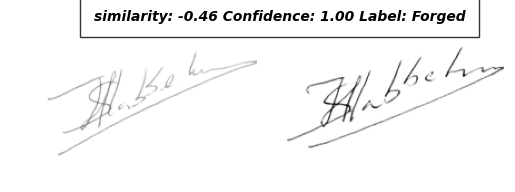

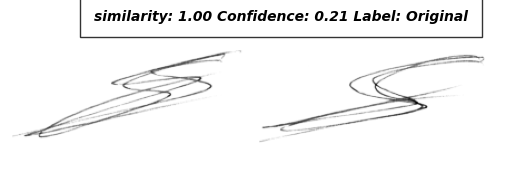

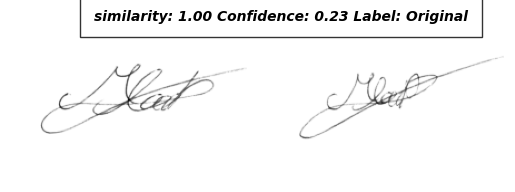

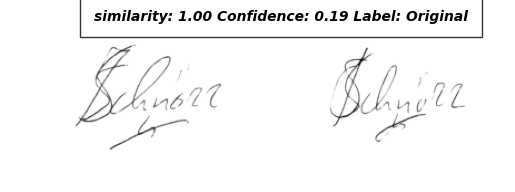

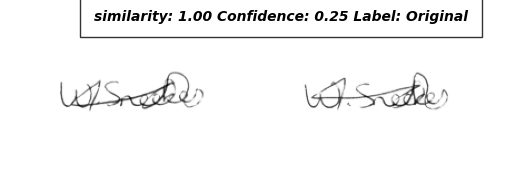

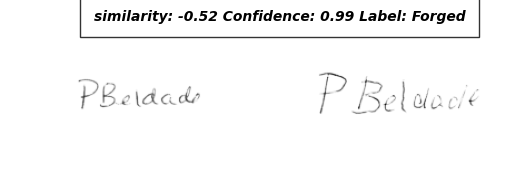

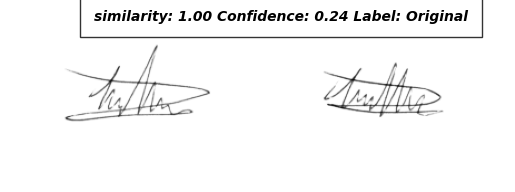

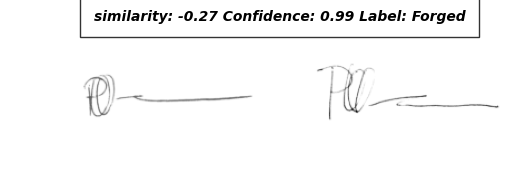

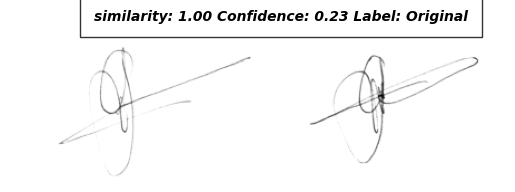

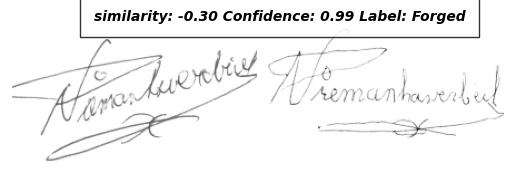

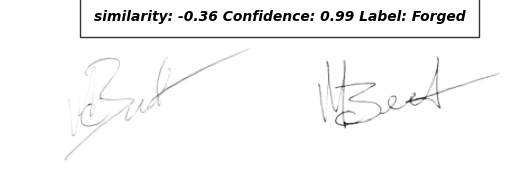

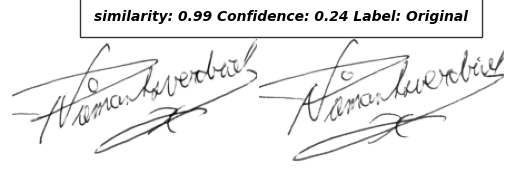

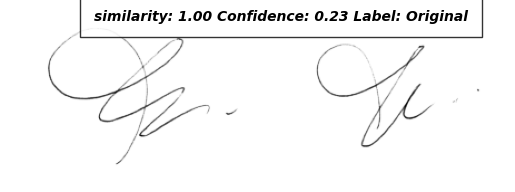

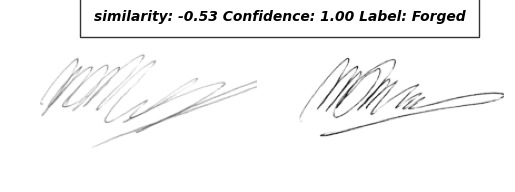

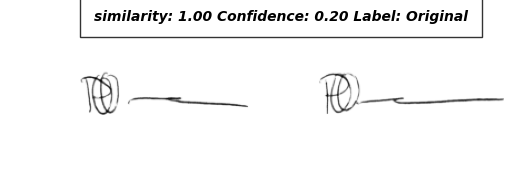

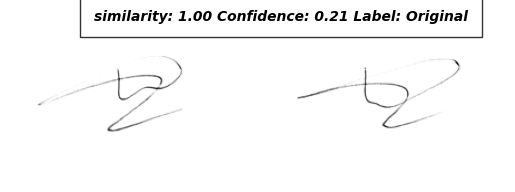

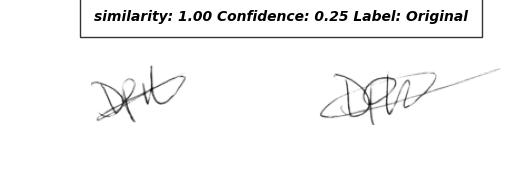

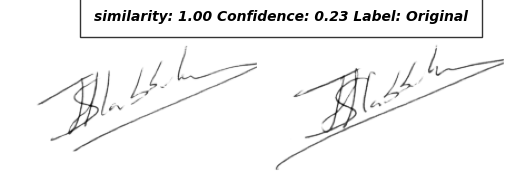

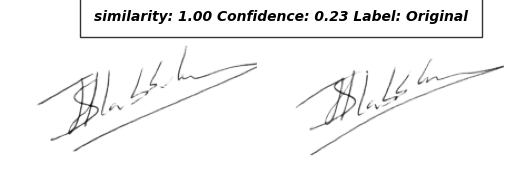

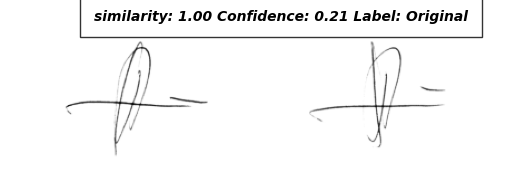

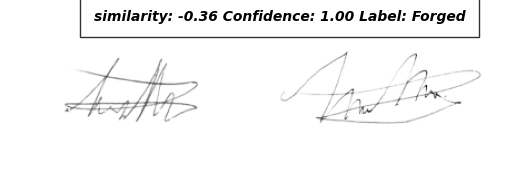

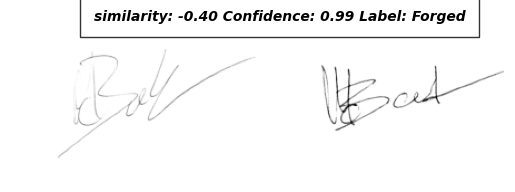

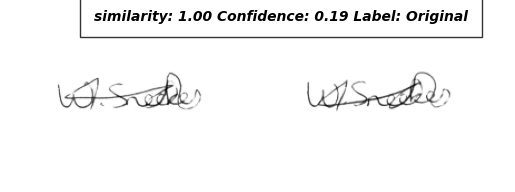

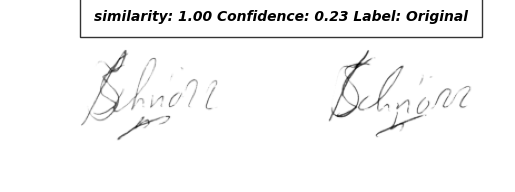

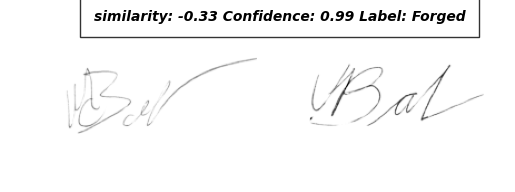

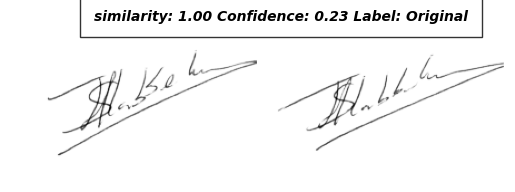

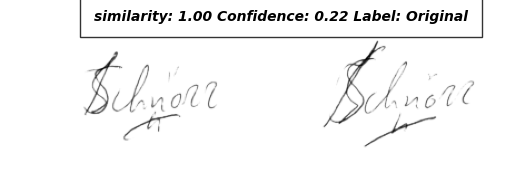

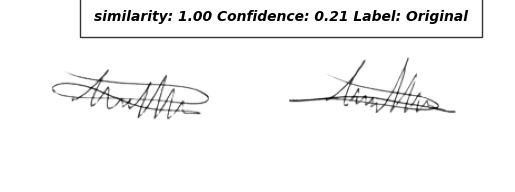

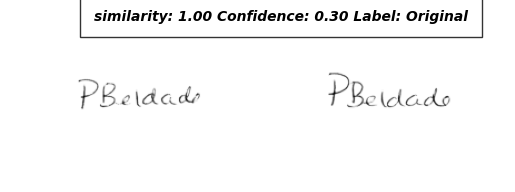

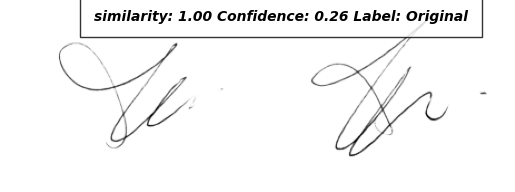

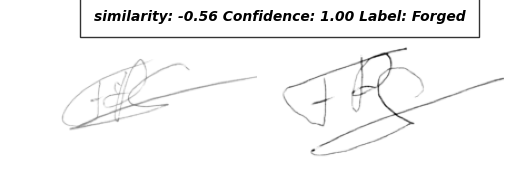

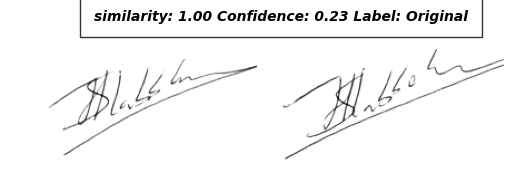

<Figure size 640x480 with 0 Axes>

In [24]:
###### Inference

seed_torch(seed=Config.seed)
model = SiameseModel()
model.load_state_dict(torch.load('./convnet_best_loss.pt')['model'])

test_dataset = SignatureDataset(test_df, Config.canvas_size, dim=(256, 256))

test_loader = DataLoader(test_dataset,
                              batch_size=1, 
                              shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)

counter = 0 
label_dict = {1.0:'Forged', 0.0:'Original'}

#CFG.projection2d=True
model.eval()
for i, data in enumerate(test_loader, 0):
    img1, img2, label = data
    concatenated = torch.cat((img1, img2),0)
    with torch.no_grad():
        op1, op2, confidence = model(img1.to('cpu'), img2.to('cpu'))
    confidence = confidence.sigmoid().detach().to('cpu')
    if label == 0.0:
        confidence = 1 - confidence
    cos_sim = F.cosine_similarity(op1, op2)

    imshow(torchvision.utils.make_grid(concatenated.unsqueeze(1)), f'similarity: {cos_sim.item():.2f} Confidence: {confidence.item():.2f} Label: {label_dict[label.item()]}')
    plt.savefig('siamese.png')
    counter+=1
    if counter==40:
        break